In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from scipy import stats

### データの読み込み

In [85]:
def chck_tserr(ts):
    assert ((ts.shape[1] == 2) or (ts.shape[1] == 3)), "TS SHAPE ERROR"

    if ts.shape[1] == 2:
        ts_fill = np.zeros((ts.shape[0], 3))
        ts_fill[:,0:2] = ts[:,0:2]
        return ts_fill

    else:
        return ts

In [86]:
def get_timeseries(ts1_in, ts2_in, vrbs, plyft):
    ts1 = chck_tserr(ts1_in)
    ts2 = chck_tserr(ts2_in)

    ts1, ts2 = set_unitytime(ts1, ts2)
    ts1 = tsdtrnd(ts1, vrbs, plyft)
    ts2 = tsdtrnd(ts2, vrbs, plyft)

    return ts1, ts2

(1088, 3) (1085, 3)


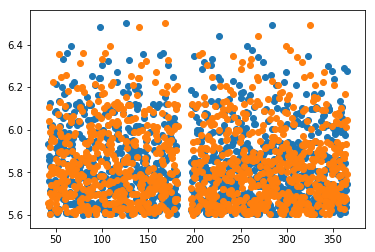

In [87]:
infile1 = pd.read_csv('../../../source/pydcf/example/ts1.csv', header=None)
infile2 = pd.read_csv('../../../source/pydcf/example/ts2.csv', header=None)
ts1_in = infile1.values
ts2_in = infile2.values
print(ts1_in.shape, ts2_in.shape)
plt.scatter(infile1[0], infile1[1])
plt.scatter(infile2[0], infile2[1])

In [88]:
def set_unitytime(ts1, ts2):
    unitytime = min(np.min(ts1[:, 0]), np.min(ts2[:, 0]))
    ts1[:, 0] = ts1[:, 0] - unitytime
    ts2[:, 0] = ts2[:, 0] - unitytime

    return ts1, ts2

In [89]:
def tsdtrnd(ts, vrbs, plyft):
    if plyft == 0:
        ts_mean = np.mean(ts[:, 1])
        ts[:, 1] = ts[:, 1] - ts_mean
        if vrbs:
            print("Mean subtraction: %.4e" %ts_mean)

    elif plyft == 1:
        from scipy.optimize import curve_fit
        lnfnc = lambda x, a, b: a*x + b
        p0, c0 = curve_fit(lnfnc, ts[:,0], ts[:,1], sigma=ts[:,2])
        ts[:,1] = ts[:,1] - lnfnc(ts[:,0], p0[0], p0[1])

        if vrbs:
            print("Linear De-trend Coefficients [a*x + b]")
            print("a:", p0[0])
            print("b:", p0[1])

    else:
        from scipy.optimize import curve_fit
        lnfnc = lambda x, a, b, c: a*x**2.0 + b*x + c
        p0, c0 = curve_fit(lnfnc, ts[:,0], ts[:,1], sigma=ts[:,2])
        ts[:,1] = ts[:,1] - lnfnc(ts[:,0], p0[0], p0[1], p0[2])

        if vrbs:
            print("Quadratic De-trend Coefficients [a*x**2 + b*x + c]")
            print("a:", p0[0])
            print("b:", p0[1])
            print("c:", p0[2])

    return ts

Mean subtraction: 5.8347e+00
Mean subtraction: 5.8400e+00
(1088, 3) (1085, 3)


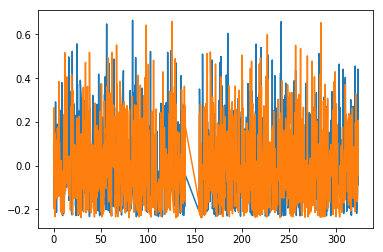

In [90]:
polyfit = 0
TS1, TS2 = get_timeseries(ts1_in, ts2_in, True, polyfit)
print(TS1.shape, TS2.shape)
plt.plot(TS1[:, 0], TS1[:, 1])
plt.plot(TS2[:, 0], TS2[:, 1])

In [92]:
lgh = 100
lgl = -100
dt = 1.5

DT = dt
N = np.around((lgh - lgl) / float(DT))
T = np.linspace(lgl+(DT/2.0), lgh-(DT/2.0), N)

DT, N, T

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


(1.5, 133.0, array([-99.25      , -97.74621212, -96.24242424, -94.73863636,
        -93.23484848, -91.73106061, -90.22727273, -88.72348485,
        -87.21969697, -85.71590909, -84.21212121, -82.70833333,
        -81.20454545, -79.70075758, -78.1969697 , -76.69318182,
        -75.18939394, -73.68560606, -72.18181818, -70.6780303 ,
        -69.17424242, -67.67045455, -66.16666667, -64.66287879,
        -63.15909091, -61.65530303, -60.15151515, -58.64772727,
        -57.14393939, -55.64015152, -54.13636364, -52.63257576,
        -51.12878788, -49.625     , -48.12121212, -46.61742424,
        -45.11363636, -43.60984848, -42.10606061, -40.60227273,
        -39.09848485, -37.59469697, -36.09090909, -34.58712121,
        -33.08333333, -31.57954545, -30.07575758, -28.5719697 ,
        -27.06818182, -25.56439394, -24.06060606, -22.55681818,
        -21.0530303 , -19.54924242, -18.04545455, -16.54166667,
        -15.03787879, -13.53409091, -12.03030303, -10.52651515,
         -9.02272727,  -7.51

In [94]:
def sdcf(ts1, ts2, t, dt):

    '''
        Subroutine - sdcf
          DCF algorithm with slot weighting
    '''

    dcf = np.zeros(t.shape[0])
    dcferr = np.zeros(t.shape[0])
    n = np.zeros(t.shape[0])

    dst = np.empty((ts1.shape[0], ts2.shape[0]))
    for i in range(ts1.shape[0]):
        for j in range(ts2.shape[0]):
            dst[i,j] = ts2[j,0] - ts1[i,0]

    for k in range(t.shape[0]):
        tlo = t[k] - dt/2.0
        thi = t[k] + dt/2.0
        ts1idx, ts2idx = np.where((dst < thi) & (dst > tlo))

        mts2 = np.mean(ts2[ts2idx,1])
        mts1 = np.mean(ts1[ts1idx,1])
        n[k] = ts1idx.shape[0]

        dcfdnm = np.sqrt((np.var(ts1[ts1idx,1]) - np.mean(ts1[ts1idx,2])**2) \
                         * (np.var(ts2[ts2idx,1]) - np.mean(ts2[ts2idx,2])**2))

        dcfs = (ts2[ts2idx,1] - mts2) * (ts1[ts1idx,1] - mts1) / dcfdnm

        dcf[k] = np.sum(dcfs) / float(n[k])
        dcferr[k] = np.sqrt(np.sum((dcfs - dcf[k])**2)) / float(n[k] - 1)

    return dcf, dcferr

In [98]:
def gdcf(ts1, ts2, t, dt):

    '''
        Subroutine - gdcf
          DCF algorithm with gaussian weighting
    '''

    h = dt/4.0
    gkrn = lambda x: np.exp(-1.0 * np.abs(x)**2 / (2.0 * h**2)) \
           / np.sqrt(2.0 * np.pi * h)
    cntrbt = gkrn(3.290527*h)

    dcf = np.zeros(t.shape[0])
    dcferr = np.zeros(t.shape[0])
    n = np.zeros(t.shape[0])

    dst = np.empty((ts1.shape[0], ts2.shape[0]))
    for i in range(ts1.shape[0]):
        for j in range(ts2.shape[0]):
            dst[i,j] = ts2[j,0] - ts1[i,0]

    for k in range(t.shape[0]):
        gdst = gkrn(dst - t[k])
        ts1idx, ts2idx = np.where(gdst >= cntrbt)

        mts2 = np.mean(ts2[ts2idx,1])
        mts1 = np.mean(ts1[ts1idx,1])
        n[k] = ts1idx.shape[0]

        dcfdnm = np.sqrt((np.var(ts1[ts1idx,1]) - np.mean(ts1[ts1idx,2])**2) \
                         * (np.var(ts2[ts2idx,1]) - np.mean(ts2[ts2idx,2])**2))

        dcfs = (ts2[ts2idx,1] - mts2) * (ts1[ts1idx,1] - mts1) / dcfdnm
        dcf[k] = np.sum(dcfs) / float(n[k])
        dcferr[k] = np.sqrt(np.sum((dcfs - dcf[k])**2)) / float(n[k] - 1)

    return dcf, dcferr

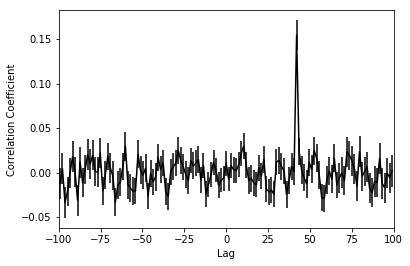

CPU times: user 1.52 s, sys: 16 ms, total: 1.54 s
Wall time: 1.54 s


In [100]:
%%time
weight = 'slot'
DCF, DCFERR = sdcf(TS1, TS2, T, DT)

plt.figure(0)
plt.errorbar(T, DCF, DCFERR, color='k', ls='-', capsize=0)
plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient")
plt.xlim(lgl, lgh)
plt.show()

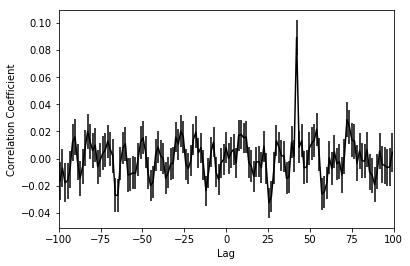

CPU times: user 39.5 s, sys: 990 ms, total: 40.5 s
Wall time: 10.6 s


In [101]:
%%time
weight = 'gauss'
DCF, DCFERR = gdcf(TS1, TS2, T, DT)

plt.figure(0)
plt.errorbar(T, DCF, DCFERR, color='k', ls='-', capsize=0)
plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient")
plt.xlim(lgl, lgh)
plt.show()